# Capstone Project - The Battle of the Neighborhoods 
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [1.Introduction: Business Problem](#introduction)
* [2.Data](#data)
* [3.Methodology](#methodology)
* [4.Analysis](#analysis)
* [5.Results](#results)
* [6.Discussion](#discussion)
* [7.Conclusion](#conclusion)

## 1. Introduction: Business Problem <a name="introduction"></a>

#### 1.1 Background

Choosing the right commercial location in local neighborhood can help businesses owners meet and exceed their sales and marketing goal. Location and Postcode analysis offer business the ability to combine all geographically relevant demographic, economic, and sociopolitical information with financial and other data that businesses generally possess. 

Johnson County is a county with highest population and large number of employers in Kansas State. Restaurant owner is interested in exploring the population and business patterns in Johnson County neighborhood to discover the best location to open a pizza restaurant. Setting up pizza shop near an area with a lot of vehicle traffic and stable household income families will take the business to the next level. 

#### 1.2 Problem

Data contribute to making decision on pizza place location include venue category, venue address, distance to entrance, cross street, neighborhood postcode, neighborhood employee numbers, and neighborhood employee payrolls. 

The aim of this project is to predict whether the given location in Johnson County is the best choice to start a pizza business. 

## 2. Data <a name="data"></a>

#### 2.1 Data Description

Data to consider when choosing a pizza restaurant location involves: 
* Demographics information extracted from [Census API tool](https://api.census.gov/data.html); 
* Business vendor information extracted from [Foursquare API Too](https://developer.foursquare.com/docs/api-reference/venues/search/); 
* Johnson County zip code data from [Mongabay Zip Data](https://data.mongabay.com/igapo/zip_codes/metropolitan-areas/metro-zip/Kansas%20City%20(MO-KS)1.html).

The census database I used in this project is 2017 Economic Annual Surveys. The basis of reporting ZIP Code Business Patterns is tabulated at the establishment level. An establishment is a single physical location at which business is conducted. Number of employees and annual payroll for each zip code area are extracted to add to this project model. Thus, the household wealthiness and the number target customers are added to the prediction modal as parameters. Johnson Count Business vendor data including vendor location, vendor cross street, distance to entrance, business categories is added to my analysis. I found the location by zip code level from Mongabay by use of Beautiful Soup to scrape the web.




#### 2.2 Data Wrangling

##### 2.21 Import Data and handle missing values

Import all the libraries and packages

In [1]:
!conda install bs4 --yes
from bs4 import BeautifulSoup
from urllib.request import urlopen
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

!conda install -c conda-forge folium=0.5.0 --yes
import folium
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 


Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - bs4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.9.0       |           py36_0         167 KB
    bs4-4.9.0                  |                0           9 KB
    ca-certificates-2020.1.1   |                0         125 KB
    certifi-2020.4.5.1         |           py36_0         155 KB
    openssl-1.1.1g             |       h7b6447c_0         2.5 MB
    soupsieve-2.0              |             py_0          33 KB
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be INSTALLED:

  beautifulsoup4     pkgs/main/linux-64::beautifulsoup4-4.9.0-py36_0
  bs4                pkgs/main/noarch::bs4-4.9.0-0
  soupsieve          pkg

First to create latitude & longitude coordinates for centroids of Johnson county, KS neighborhoods. BeautifulSoup is used to capture zip codes of cities in Johnson County, from [Mongabay Zip Data](https://data.mongabay.com/igapo/zip_codes/metropolitan-areas/metro-zip/Kansas%20City%20(MO-KS)1.html).

In [2]:
 
f = requests.get('https://data.mongabay.com/igapo/zip_codes/metropolitan-areas/metro-zip/Kansas%20City%20(MO-KS)1.html') 

kc_data = BeautifulSoup(f.text)
match = kc_data.find('table', class_='boldtable')


In [3]:
rows = match.find_all ('tr')
 
dt_kc=[]
for r in range(len(rows)):
    
    dt_kctext = rows[r].find_all('td')
    temp=[]
    
    for val in dt_kctext:
        temp.append(val.text)
    dt_kc.append(temp)

    


column = ['postal','phone','county','state','city','district']

df = pd.DataFrame(dt_kc, columns=column)

df['Postal Code'] = df['postal'].str[:5]
 
df['postal'] = df['postal'].str[5:]

df_kc = df.rename(columns={'postal':'city_name'})
 
df_kc = df_kc[['city_name','Postal Code','county','state']]
df_johnson = df_kc.loc[df['county'] =='Johnson County']
 
print(df_johnson)
 

            city_name Postal Code          county        state
276           De Soto       66018  Johnson County  Kansas - KS
277    Clearview City       66019  Johnson County  Kansas - KS
278           De Soto       66019  Johnson County  Kansas - KS
280          Edgerton       66021  Johnson County  Kansas - KS
284           Gardner       66030  Johnson County  Kansas - KS
..                ...         ...             ...          ...
482   Shawnee Mission       66285  Johnson County  Kansas - KS
483                Sm       66285  Johnson County  Kansas - KS
484            Lenexa       66286  Johnson County  Kansas - KS
485           Shawnee       66286  Johnson County  Kansas - KS
486   Shawnee Mission       66286  Johnson County  Kansas - KS

[177 rows x 4 columns]


Add the latitude & longitude keys to each city centers with pgeocode.Nominatim package. 

In [4]:
!pip install pgeocode

In [5]:
import pgeocode

nomi = pgeocode.Nominatim('us')

df_loc=[]
for i in df_johnson['Postal Code']:
    df_loc.append(nomi.query_postal_code(i))
    
column=['postal_code','country code','place_name','state_name', 'county_name','county_code','community_name','community_code','latitude','longitude','accuracy']
df_j = pd.DataFrame(df_loc, columns = column)
df_p=df_j.reset_index(drop=True) 
df_po=df_p[['postal_code','latitude','longitude']]
df_po=df_po.rename(columns={'postal_code':'Postal Code'})


In [6]:
df_jo = pd.merge(df_johnson,df_po, how='right', on='Postal Code')
#df_jo = df_johnson.append(df_po, sort=False)
df_jo

,city_name,Postal Code,county,state,latitude,longitude
0,De Soto,66018,Johnson County,Kansas - KS,38.9462,-94.9714
1,Clearview City,66019,Johnson County,Kansas - KS,NaN,NaN
2,De Soto,66019,Johnson County,Kansas - KS,NaN,NaN
3,Clearview City,66019,Johnson County,Kansas - KS,NaN,NaN
4,De Soto,66019,Johnson County,Kansas - KS,NaN,NaN
...,...,...,...,...,...,...
866,Shawnee,66286,Johnson County,Kansas - KS,39.0417,-94.7202
867,Shawnee Mission,66286,Johnson County,Kansas - KS,39.0417,-94.7202
868,Lenexa,66286,Johnson County,Kansas - KS,39.0417,-94.7202
869,Shawnee,66286,Johnson County,Kansas - KS,39.0417,-94.7202


Clean data, drop NA and duplicate data. Concatenate city areas with same postal code so I am able to use zip code to search for business venues with a radius of 1500 meters. 

In [7]:
df_jo=df_jo.drop_duplicates().dropna().reset_index(drop=True)
df_jon = pd.DataFrame(columns = list(df_jo.columns))
zips = set(df_jo['Postal Code'])
for zipp in zips:
    rows = df_jo[df_jo['Postal Code'] == zipp].reset_index(drop=True)
    city_names = rows['city_name'].tolist()
    city_name = '/'.join(city_names)
    new_row = {}
    new_row['city_name'] = city_name
    for col in list(rows.columns):
        if col is not 'city_name':
            new_row[col] = rows.loc[0][col]
    df_jon.loc[len(df_jon)] = new_row
df_jon


,city_name,Postal Code,county,state,latitude,longitude
0,Shawnee/ Shawnee Mission/ Sm,66218,Johnson County,Kansas - KS,39.0417,-94.7202
1,Overland/ Overland Park/ Shawnee Mission/ Sm/...,66223,Johnson County,Kansas - KS,38.8619,-94.6610
2,Overland/ Overland Park/ Shawnee Mission/ Sm,66282,Johnson County,Kansas - KS,38.8999,-94.8320
3,Lenexa/ Olathe/ Overland Park,66062,Johnson County,Kansas - KS,38.8733,-94.7752
4,Lenexa/ Overland/ Overland Park/ Shawnee Miss...,66215,Johnson County,Kansas - KS,38.9536,-94.7336
5,Lenexa/ Shawnee/ Shawnee Mission/ Sm,66227,Johnson County,Kansas - KS,38.9536,-94.7336
6,Lenexa/ Op/ Overland Park/ Shawnee Mission/ S...,66251,Johnson County,Kansas - KS,38.8999,-94.8320
7,Merriam/ Overland/ Overland Park/ Prairie Vil...,66204,Johnson County,Kansas - KS,38.9928,-94.6771
8,Edgerton,66021,Johnson County,Kansas - KS,38.7811,-95.0094
9,Spring Hill,66083,Johnson County,Kansas - KS,38.7631,-94.8246


#### Foursquare

Use Foursquare API to get venue informations in each city neighborhood. First to take a look at the data pattern for each venue in Olathe neighborhood. So I am able to do further analysis to extract useful information to add to models as key parameter.  

In [8]:
address = 'Olathe, KS'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of olathe are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of olathe are 38.8838856, -94.81887.


In [10]:
CLIENT_ID = 'FU3FNGEIK2IW5VS01MZC1ZVR2W20LSCEZOUCIDBB2WOU051W' # your Foursquare ID
CLIENT_SECRET = '3DCGCPEJ4YIEDGTY5QMLI3MPS3CLWLA2SOZRIOU2OUGOPCMS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100
radius = 1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
results = requests.get(url).json()
results

 

{'meta': {'code': 200, 'requestId': '5ebc40f202a172001b31a55d'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Central Core',
  'headerFullLocation': 'Central Core, Olathe',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 14,
  'suggestedBounds': {'ne': {'lat': 38.89288560900001,
    'lng': -94.80732969008133},
   'sw': {'lat': 38.87488559099999, 'lng': -94.83041030991868}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bd1ecbc046076b029d17271',
       'name': 'Kansas Coffee Café',
       'location': {'address': '101 E Park St',
        'crossStreet': 'at N Cherry St.',
        'lat': 38.881981099879475,
        'lng': -94.81945893487695,
        'labeledLatLn

As I can tell from the above database, the following factors will be considered when choosing the business location: 
* Access: One of the most important factors is how accessible your potential location is. Distance to entrance and crossroad information need to be added to the API  request.
* Business type: business type is what I need predict for.  This item will be added to my test/train model.
* Popularity of the business: All the venues in Johnson County area have not been rated based on the data pulled from Foursquare.  I will skip this part.
* Tax: The restaurant business income rates and sales tax rates imposed on customer are not changed too much within Johnson County. Combined tax rate for Johnson County is 9.48%.


In [9]:
CLIENT_ID = 'FU3FNGEIK2IW5VS01MZC1ZVR2W20LSCEZOUCIDBB2WOU051W' # your Foursquare ID
CLIENT_SECRET = '3DCGCPEJ4YIEDGTY5QMLI3MPS3CLWLA2SOZRIOU2OUGOPCMS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [10]:
def getNearbyVenues(names,postal, latitudes, longitudes):
    
    venues_list=[]
    LIMIT = 100
    radius = 1500
    for cname,pos,lat,lng in zip(names,postal,latitudes,longitudes):
 
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        for v in results:
            try:
                venues_list.append([(
                cname,
                pos,
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],
                v['venue']['location']['distance'],
                v['venue']['categories'][0]['name'],
                v['venue']['location']['crossStreet'])])
        
           
            except:
                venues_list.append([(
                cname,
                pos,
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],
                v['venue']['location']['distance'],
                v['venue']['categories'][0]['name'],
                'NA')])
         

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])

    nearby_venues.columns = ['City',
                  'Postal Code',
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Dis to entrance',
                  'Venue Category',
                  'Venue crosssSreet',]
    
    return(nearby_venues)

In [11]:
jo_venues = getNearbyVenues(names=df_jon['city_name'],
                            postal=df_jon['Postal Code'],
                            longitudes=df_jon['longitude'],
                            latitudes=df_jon['latitude']
                            )

jo_venues

,City,Postal Code,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Dis to entrance,Venue Category,Venue crosssSreet
0,Shawnee/ Shawnee Mission/ Sm,66218,39.0417,-94.7202,West Flanders Park,39.030392,-94.713196,1396,Park,Near Johnson Dr.
1,Shawnee/ Shawnee Mission/ Sm,66218,39.0417,-94.7202,West Flanders Park & Walking Trail,39.029862,-94.713282,1447,Park,nieman
2,Shawnee/ Shawnee Mission/ Sm,66218,39.0417,-94.7202,Service Source,39.041227,-94.723396,281,Other Repair Shop,at Country Line Rd
3,Shawnee/ Shawnee Mission/ Sm,66218,39.0417,-94.7202,Black Swan Lake,39.041802,-94.730938,928,Lake,NA
4,Shawnee/ Shawnee Mission/ Sm,66218,39.0417,-94.7202,Bierman's Christmas Tree Farm,39.049750,-94.723537,941,Garden Center,NA
...,...,...,...,...,...,...,...,...,...,...
1784,Leawood/ Overland/ Overland Park/ Shawnee Mis...,66211,38.9667,-94.6169,Ceramic Café,38.957999,-94.629457,1455,Arts & Crafts Store,NA
1785,Leawood/ Overland/ Overland Park/ Shawnee Mis...,66211,38.9667,-94.6169,We B Nuts And Stuff,38.957999,-94.629457,1455,Dessert Shop,NA
1786,Leawood/ Overland/ Overland Park/ Shawnee Mis...,66211,38.9667,-94.6169,Hallmark Creations,38.958188,-94.629920,1472,Gift Shop,NA
1787,Leawood/ Overland/ Overland Park/ Shawnee Mis...,66211,38.9667,-94.6169,Oz's MAQ Donut House,38.956166,-94.627651,1497,Donut Shop,NA


In [12]:
jo_pc=jo_venues.groupby('Postal Code').count()

Now, I will use census API tool to collect demographics data for the Johnson County neighborhood. The census database I used in this project is 2017 Economic Annual Surveys. Employee numbers and annual payroll ($1,000) are two variables which will be considered.  So restaurants owner are able to make judgment on neighborhood size and neighborhood wealthness of perspective customers. 

In [13]:
def getpopinfo(zip_codes):
    jo_emp=[]
    zip_list=[]
    for zip_code in zip_codes:
        url = 'https://api.census.gov/data/2017/zbp?get=NAICS2017_LABEL,EMP,GEO_ID,PAYANN,EMPSZES_LABEL&for=zip%20code:{}&NAICS2017=00&key=234d6c235a105e7e50723b5e4e747b03c4692a24'.format(
        zip_code)
        
        res = requests.get(url)
        
        try:
            zip_list.append(res.json()[1])           
        except:
            pass
        
    column= res.json()[0]
    jo_emp = pd.DataFrame(zip_list,columns=column)
 

    return(jo_emp)

In [14]:
df_jovenue=df_jon['Postal Code'].values.tolist()
 

In [26]:
df_jovenues = getpopinfo(zip_codes=df_jovenue)
df_jovenues.head()

,NAICS2017_LABEL,EMP,GEO_ID,PAYANN,EMPSZES_LABEL,NAICS2017,zip code
0,Total for all sectors,1280,8610000US66218,64208,All establishments,00,66218
1,Total for all sectors,10456,8610000US66223,332174,All establishments,00,66223
2,Total for all sectors,18,8610000US66282,223,All establishments,00,66282
3,Total for all sectors,29366,8610000US66062,1224442,All establishments,00,66062
4,Total for all sectors,29052,8610000US66215,1436549,All establishments,00,66215


In [27]:
df_joks = df_jovenues.drop(['NAICS2017_LABEL','GEO_ID','EMPSZES_LABEL','NAICS2017'], axis=1).rename(columns={'EMP':'Employee No.','PAYANN':'Ann payroll','zip code':'Postal Code'})

df_joks.head()

,Employee No.,Ann payroll,Postal Code
0,1280,64208,66218
1,10456,332174,66223
2,18,223,66282
3,29366,1224442,66062
4,29052,1436549,66215


Combine all the variables in one dataset.

In [28]:
df_kcjo = pd.merge(jo_venues,df_joks, how='left', on='Postal Code')
df_kcjo

,City,Postal Code,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Dis to entrance,Venue Category,Venue crosssSreet,Employee No.,Ann payroll
0,Shawnee/ Shawnee Mission/ Sm,66218,39.0417,-94.7202,West Flanders Park,39.030392,-94.713196,1396,Park,Near Johnson Dr.,1280,64208
1,Shawnee/ Shawnee Mission/ Sm,66218,39.0417,-94.7202,West Flanders Park & Walking Trail,39.029862,-94.713282,1447,Park,nieman,1280,64208
2,Shawnee/ Shawnee Mission/ Sm,66218,39.0417,-94.7202,Service Source,39.041227,-94.723396,281,Other Repair Shop,at Country Line Rd,1280,64208
3,Shawnee/ Shawnee Mission/ Sm,66218,39.0417,-94.7202,Black Swan Lake,39.041802,-94.730938,928,Lake,NA,1280,64208
4,Shawnee/ Shawnee Mission/ Sm,66218,39.0417,-94.7202,Bierman's Christmas Tree Farm,39.049750,-94.723537,941,Garden Center,NA,1280,64208
...,...,...,...,...,...,...,...,...,...,...,...,...
1784,Leawood/ Overland/ Overland Park/ Shawnee Mis...,66211,38.9667,-94.6169,Ceramic Café,38.957999,-94.629457,1455,Arts & Crafts Store,NA,30534,2447778
1785,Leawood/ Overland/ Overland Park/ Shawnee Mis...,66211,38.9667,-94.6169,We B Nuts And Stuff,38.957999,-94.629457,1455,Dessert Shop,NA,30534,2447778
1786,Leawood/ Overland/ Overland Park/ Shawnee Mis...,66211,38.9667,-94.6169,Hallmark Creations,38.958188,-94.629920,1472,Gift Shop,NA,30534,2447778
1787,Leawood/ Overland/ Overland Park/ Shawnee Mis...,66211,38.9667,-94.6169,Oz's MAQ Donut House,38.956166,-94.627651,1497,Donut Shop,NA,30534,2447778


##### 2.22 Data Data Standarization and Data Normalization

Identify pizza place from venue category and transform this category item to numerical value. This is predicted value I will use to build models. Venue crosssStreet also needs to be transform to numerical value. All the NA values will be transform to 0. 

In [29]:
df_kcjo['Venue Category'].value_counts()

Clothing Store        91
Pizza Place           76
Sandwich Place        59
Mexican Restaurant    56
Coffee Shop           49
                      ..
Dog Run                1
Music Store            1
Bike Shop              1
High School            1
Tex-Mex Restaurant     1
Name: Venue Category, Length: 169, dtype: int64

In [30]:
new=df_kcjo.copy()

new.loc[new['Venue Category'] == 'Pizza Place', 'Venue Category'] = 1
new.loc[new['Venue Category'] != 1, 'Venue Category'] = 0

new_jo=pd.to_numeric(new['Venue Category'], downcast='float')
new['Venue Category']=new_jo
new.dtypes

City                      object
Postal Code               object
Latitude                 float64
Longitude                float64
Venue                     object
Venue Latitude           float64
Venue Longitude          float64
Venue Dis to entrance      int64
Venue Category           float32
Venue crosssSreet         object
Employee No.              object
Ann payroll               object
dtype: object

In [31]:
new['Venue Category'].value_counts()

0.0    1713
1.0      76
Name: Venue Category, dtype: int64

In [32]:
df_kcjonson=new.copy()

df_kcjonson.loc[df_kcjonson['Venue crosssSreet'] == 'NA', 'Venue crosssSreet'] = 1
df_kcjonson.loc[df_kcjonson['Venue crosssSreet'] != 1, 'Venue crosssSreet'] = 0

new_jon=pd.to_numeric(df_kcjonson['Venue crosssSreet'], downcast='float')
df_kcjonson['Venue crosssSreet']=new_jon


new_jonkc=pd.to_numeric(df_kcjonson['Employee No.'], downcast='float')
df_kcjonson['Employee No.']=new_jonkc

new_jonkan=pd.to_numeric(df_kcjonson['Ann payroll'], downcast='float')
df_kcjonson['Ann payroll']=new_jonkan

new_jonkanp=pd.to_numeric(df_kcjonson['Postal Code'], downcast='float')
df_kcjonson['Postal Code']=new_jonkanp

df_kcjonson.dtypes

City                      object
Postal Code              float32
Latitude                 float64
Longitude                float64
Venue                     object
Venue Latitude           float64
Venue Longitude          float64
Venue Dis to entrance      int64
Venue Category           float32
Venue crosssSreet        float32
Employee No.             float32
Ann payroll              float32
dtype: object

In [33]:
df_kcjonson

,City,Postal Code,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Dis to entrance,Venue Category,Venue crosssSreet,Employee No.,Ann payroll
0,Shawnee/ Shawnee Mission/ Sm,66218.0,39.0417,-94.7202,West Flanders Park,39.030392,-94.713196,1396,0.0,0.0,1280.0,64208.0
1,Shawnee/ Shawnee Mission/ Sm,66218.0,39.0417,-94.7202,West Flanders Park & Walking Trail,39.029862,-94.713282,1447,0.0,0.0,1280.0,64208.0
2,Shawnee/ Shawnee Mission/ Sm,66218.0,39.0417,-94.7202,Service Source,39.041227,-94.723396,281,0.0,0.0,1280.0,64208.0
3,Shawnee/ Shawnee Mission/ Sm,66218.0,39.0417,-94.7202,Black Swan Lake,39.041802,-94.730938,928,0.0,1.0,1280.0,64208.0
4,Shawnee/ Shawnee Mission/ Sm,66218.0,39.0417,-94.7202,Bierman's Christmas Tree Farm,39.049750,-94.723537,941,0.0,1.0,1280.0,64208.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1784,Leawood/ Overland/ Overland Park/ Shawnee Mis...,66211.0,38.9667,-94.6169,Ceramic Café,38.957999,-94.629457,1455,0.0,1.0,30534.0,2447778.0
1785,Leawood/ Overland/ Overland Park/ Shawnee Mis...,66211.0,38.9667,-94.6169,We B Nuts And Stuff,38.957999,-94.629457,1455,0.0,1.0,30534.0,2447778.0
1786,Leawood/ Overland/ Overland Park/ Shawnee Mis...,66211.0,38.9667,-94.6169,Hallmark Creations,38.958188,-94.629920,1472,0.0,1.0,30534.0,2447778.0
1787,Leawood/ Overland/ Overland Park/ Shawnee Mis...,66211.0,38.9667,-94.6169,Oz's MAQ Donut House,38.956166,-94.627651,1497,0.0,1.0,30534.0,2447778.0


In [34]:
 
map_jo = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, city in zip(df_kcjonson['Venue Latitude'], df_kcjonson['Venue Longitude'], df_kcjonson['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_jo)  
    
map_jo

## 3.  Methodology <a name="methodology"></a>

I will focus on detecting the business pattern in the area of Johnson County. Try to find the correlation of different variables for pizza shops in Johnson County.  The analysis is limited to area 1.5 km around city centers. 

Firstly, based on the folium library visualize geographic details,  I will emphasize on Segmenting and Clustering model (k-means clustering) to check the business density, and business types in Johnson County.  The plot map shows the density of existing various venues and especially pizza shops in Johnson County neighborhood. 

Secondly, 77 pizza shops out of 1765 venues are located in Johnson County areas. I will use Sklearn and matplotlib to build different models to predict whether the chosen location is the best choice with comparable easy access to entrance and prospective customers with comparable stable household income. 

Next, logistic regression, SVM and Decision tree models will be applied to my dataset. After train and test the dataset, jaccard index and F1 Score and decision tree accuracy score will be used for accuracy evaluation. By choosing the best model and together with the consideration of the clustering model result, I can narrow down the best pizza shop location a city centroid within 250 meters. 
 



## 4.  Analysis <a name="analysis"></a>

Firstly I will do research on the business category within Johnson County and dig in further from the venue dataset by using k means cluster method and create a map showing the pizza shop density in neighborhood. 

The primary reason is that clustering creates groups from continuous variables, so if you’re looking to create groups, clustering does a really nice job of finding the boundaries between groups for you. Venue segmentation is the process of dividing venues into groups based upon certain boundaries; clustering is one way to generate these boundaries. Lastly, I’m using the k-means clustering technique because it can efficiently handle large datasets and iterates quickly to good solutions.   

The Johnson County venues are segmented based upon the business categories.  Within the 169 different business categories in Johnson County neighborhood, the business category which appears most often is labeled as 1st  most common venue.  I choose the first 10 most common venues to establish 7 groups.  Each group is clustered upon the frequency of same business category. I can conclude from below category map and cluster 0 output: most of the recreation and food business are centralized in first cluster which is located Overland park and Olathe areas.  

In [35]:
jo_onehot = pd.get_dummies(jo_venues[['Venue Category']], prefix="", prefix_sep="")

jo_onehot[['Postal Code']] = jo_venues[['Postal Code']]
 

fixed_columns = [jo_onehot.columns[-1]] + list(jo_onehot.columns[:-1])
jo_onehot = jo_onehot[fixed_columns]

jo_onehot.head()

,Postal Code,ATM,Accessories Store,Airport,Airport Terminal,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,...,Thrift / Vintage Store,Toy / Game Store,Trail,Video Game Store,Video Store,Volleyball Court,Warehouse Store,Weight Loss Center,Women's Store,Yoga Studio
0,66218,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,66218,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,66218,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,66218,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,66218,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
jo_grouped = jo_onehot.groupby('Postal Code').mean().reset_index()
jo_grouped.head()

,Postal Code,ATM,Accessories Store,Airport,Airport Terminal,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,...,Thrift / Vintage Store,Toy / Game Store,Trail,Video Game Store,Video Store,Volleyball Court,Warehouse Store,Weight Loss Center,Women's Store,Yoga Studio
0,66018,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
1,66021,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
2,66030,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.02439,0.000000,0.0,0.0,0.0,0.0
3,66031,0.0,0.0,0.090909,0.090909,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.090909,0.0,0.0,0.0,0.0
4,66051,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.10000,0.000000,0.0,0.0,0.0,0.0


In [51]:
 def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal Code'] = jo_grouped['Postal Code']
 
for ind in np.arange(jo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(jo_grouped.iloc[ind, :], num_top_venues)


In [53]:
# set number of clusters
kclusters = 7

jo_grouped_clustering = jo_grouped.drop('Postal Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(jo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 0, 0, 3, 0, 0, 3, 0, 6], dtype=int32)

In [54]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

jo_merged = df_jon

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
jo_merged = jo_merged.join(neighborhoods_venues_sorted.set_index('Postal Code'), on='Postal Code')

jo_merged.head()

,city_name,Postal Code,county,state,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Shawnee/ Shawnee Mission/ Sm,66218,Johnson County,Kansas - KS,39.0417,-94.7202,4,Park,Home Service,Mexican Restaurant,Bar,Garden Center,Lake,Other Repair Shop,Convenience Store,Doctor's Office,Discount Store
1,Overland/ Overland Park/ Shawnee Mission/ Sm/...,66223,Johnson County,Kansas - KS,38.8619,-94.6610,0,Pizza Place,Pharmacy,Yoga Studio,Mexican Restaurant,Liquor Store,Grocery Store,Rental Car Location,Recreation Center,Pub,Plaza
2,Overland/ Overland Park/ Shawnee Mission/ Sm,66282,Johnson County,Kansas - KS,38.8999,-94.8320,3,Park,Electronics Store,Pharmacy,Fast Food Restaurant,Video Store,Gym / Fitness Center,Paintball Field,Baseball Field,Gas Station,Yoga Studio
3,Lenexa/ Olathe/ Overland Park,66062,Johnson County,Kansas - KS,38.8733,-94.7752,0,Fast Food Restaurant,Pizza Place,Cosmetics Shop,Sandwich Place,Coffee Shop,Mexican Restaurant,Discount Store,Shipping Store,Ice Cream Shop,Salon / Barbershop
4,Lenexa/ Overland/ Overland Park/ Shawnee Miss...,66215,Johnson County,Kansas - KS,38.9536,-94.7336,0,Clothing Store,Department Store,Cosmetics Shop,Shoe Store,Ice Cream Shop,American Restaurant,Mexican Restaurant,Mobile Phone Shop,Sandwich Place,Chinese Restaurant


In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(jo_merged['latitude'], jo_merged['longitude'], jo_merged['city_name'], jo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [55]:
cluster4=jo_merged.loc[jo_merged['Cluster Labels'] == 4, jo_merged.columns[[0] + list(range(1, jo_merged.shape[1]))]]
cluster4

,city_name,Postal Code,county,state,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Shawnee/ Shawnee Mission/ Sm,66218,Johnson County,Kansas - KS,39.0417,-94.7202,4,Park,Home Service,Mexican Restaurant,Bar,Garden Center,Lake,Other Repair Shop,Convenience Store,Doctor's Office,Discount Store
13,Shawnee/ Shawnee Mission/ Sm,66226,Johnson County,Kansas - KS,39.0417,-94.7202,4,Park,Home Service,Mexican Restaurant,Bar,Garden Center,Lake,Other Repair Shop,Convenience Store,Doctor's Office,Discount Store
37,Lenexa/ Shawnee/ Shawnee Mission,66286,Johnson County,Kansas - KS,39.0417,-94.7202,4,Park,Home Service,Mexican Restaurant,Bar,Garden Center,Lake,Other Repair Shop,Convenience Store,Doctor's Office,Discount Store
39,Lenexa/ Shawnee/ Shawnee Mission/ Sm,66216,Johnson County,Kansas - KS,39.0417,-94.7202,4,Park,Home Service,Mexican Restaurant,Bar,Garden Center,Lake,Other Repair Shop,Convenience Store,Doctor's Office,Discount Store
41,Merriam/ Op/ Overland/ Overland Park/ Shawnee...,66203,Johnson County,Kansas - KS,39.0417,-94.7202,4,Park,Home Service,Mexican Restaurant,Bar,Garden Center,Lake,Other Repair Shop,Convenience Store,Doctor's Office,Discount Store
42,Lake Quivira/ Lenexa/ Quivira/ Shawnee/ Shawn...,66217,Johnson County,Kansas - KS,39.0417,-94.7202,4,Park,Home Service,Mexican Restaurant,Bar,Garden Center,Lake,Other Repair Shop,Convenience Store,Doctor's Office,Discount Store


In [56]:
cluster0=jo_merged.loc[jo_merged['Cluster Labels'] ==0, jo_merged.columns[[0] + list(range(1, jo_merged.shape[1]))]]
cluster0

,city_name,Postal Code,county,state,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Overland/ Overland Park/ Shawnee Mission/ Sm/...,66223,Johnson County,Kansas - KS,38.8619,-94.6610,0,Pizza Place,Pharmacy,Yoga Studio,Mexican Restaurant,Liquor Store,Grocery Store,Rental Car Location,Recreation Center,Pub,Plaza
3,Lenexa/ Olathe/ Overland Park,66062,Johnson County,Kansas - KS,38.8733,-94.7752,0,Fast Food Restaurant,Pizza Place,Cosmetics Shop,Sandwich Place,Coffee Shop,Mexican Restaurant,Discount Store,Shipping Store,Ice Cream Shop,Salon / Barbershop
4,Lenexa/ Overland/ Overland Park/ Shawnee Miss...,66215,Johnson County,Kansas - KS,38.9536,-94.7336,0,Clothing Store,Department Store,Cosmetics Shop,Shoe Store,Ice Cream Shop,American Restaurant,Mexican Restaurant,Mobile Phone Shop,Sandwich Place,Chinese Restaurant
5,Lenexa/ Shawnee/ Shawnee Mission/ Sm,66227,Johnson County,Kansas - KS,38.9536,-94.7336,0,Clothing Store,Department Store,Cosmetics Shop,Shoe Store,Ice Cream Shop,American Restaurant,Mexican Restaurant,Mobile Phone Shop,Sandwich Place,Chinese Restaurant
7,Merriam/ Overland/ Overland Park/ Prairie Vil...,66204,Johnson County,Kansas - KS,38.9928,-94.6771,0,Mexican Restaurant,Asian Restaurant,Bakery,Sports Bar,American Restaurant,Salon / Barbershop,Pizza Place,Gym / Fitness Center,Discount Store,Gym
9,Spring Hill,66083,Johnson County,Kansas - KS,38.7631,-94.8246,0,Golf Course,Brewery,Baseball Stadium,Baseball Field,Shop & Service,Fast Food Restaurant,Yoga Studio,Food & Drink Shop,Food,Flower Shop
10,Mission/ Overland Park/ Shawnee Mission/ Sm,66201,Johnson County,Kansas - KS,39.0278,-94.6558,0,Pizza Place,Sandwich Place,Fast Food Restaurant,Mexican Restaurant,Discount Store,Coffee Shop,Clothing Store,Gym,Grocery Store,Donut Shop
11,Overland/ Overland Park/ Shawnee Mission,66212,Johnson County,Kansas - KS,38.9568,-94.6832,0,Convenience Store,Chinese Restaurant,Salon / Barbershop,Gift Shop,Coffee Shop,Liquor Store,Pharmacy,Shop & Service,Hardware Store,Intersection
14,Lenexa/ Shawnee/ Shawnee Mission/ Sm,66220,Johnson County,Kansas - KS,38.9536,-94.7336,0,Clothing Store,Department Store,Cosmetics Shop,Shoe Store,Ice Cream Shop,American Restaurant,Mexican Restaurant,Mobile Phone Shop,Sandwich Place,Chinese Restaurant
16,Leawood/ Overland/ Overland Park/ Shawnee Mis...,66224,Johnson County,Kansas - KS,38.8591,-94.6314,0,Pharmacy,Spa,Theater,Playground,Salon / Barbershop,Business Service,Burger Joint,German Restaurant,Gift Shop,Golf Course


As showing in above category map and cluster output, most of the restaurants are concentrated in the first cluster.  More specifically, pizza places are the first common venue in overland park, Shawnee Mission, Leawood and Olathe cities within radius of 1500m.  

Thus, I will emphasis on the demographics information for the pizza shops in these four areas.

In [57]:
df_pizzajoks = df_kcjonson.loc[df_kcjonson['Venue Category']==1]
df_pizzapopular=df_pizzajoks.groupby('Postal Code').count()
df_pizzapopular

,City,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Dis to entrance,Venue Category,Venue crosssSreet,Employee No.,Ann payroll
Postal Code,,,,,,,,,,,
66030.0,4,4,4,4,4,4,4,4,4,4,4
66031.0,2,2,2,2,2,2,2,2,2,2,2
66061.0,7,7,7,7,7,7,7,7,7,7,7
66062.0,3,3,3,3,3,3,3,3,3,3,3
66201.0,6,6,6,6,6,6,6,6,6,6,6
66202.0,6,6,6,6,6,6,6,6,6,6,6
66204.0,2,2,2,2,2,2,2,2,2,2,2
66205.0,6,6,6,6,6,6,6,6,6,6,6
66206.0,2,2,2,2,2,2,2,2,2,2,2


In [58]:
df_pizzajoks.sort_values(by=['Employee No.', 'Ann payroll'], ascending=False)

,City,Postal Code,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Dis to entrance,Venue Category,Venue crosssSreet,Employee No.,Ann payroll
1749,Leawood/ Overland/ Overland Park/ Shawnee Mis...,66211.0,38.9667,-94.6169,Dewey's Pizza,38.956498,-94.627741,1473,1.0,0.0,30534.0,2447778.0
1764,Leawood/ Overland/ Overland Park/ Shawnee Mis...,66211.0,38.9667,-94.6169,Sarpino's Pizzeria,38.957999,-94.629457,1455,1.0,1.0,30534.0,2447778.0
84,Lenexa/ Olathe/ Overland Park,66062.0,38.8733,-94.7752,Little Caesars Pizza,38.881883,-94.779845,1036,1.0,1.0,29366.0,1224442.0
91,Lenexa/ Olathe/ Overland Park,66062.0,38.8733,-94.7752,Papa John's Pizza,38.882953,-94.778677,1116,1.0,0.0,29366.0,1224442.0
96,Lenexa/ Olathe/ Overland Park,66062.0,38.8733,-94.7752,Pizza Street,38.885044,-94.781383,1412,1.0,1.0,29366.0,1224442.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1608,Mission/ Shawnee Mission/ Sm,66222.0,39.0278,-94.6558,Toppers Pizza,39.019696,-94.667138,1332,1.0,1.0,112.0,3275.0
1610,Mission/ Shawnee Mission/ Sm,66222.0,39.0278,-94.6558,Domino's Pizza,39.021991,-94.648405,909,1.0,1.0,112.0,3275.0
1611,Mission/ Shawnee Mission/ Sm,66222.0,39.0278,-94.6558,Pizza Hut,39.022433,-94.661135,754,1.0,1.0,112.0,3275.0
981,J C Penney Co/ Shawnee Mission/ Sm,66250.0,38.9536,-94.7336,Pie Five Pizza,38.957171,-94.726809,709,1.0,1.0,0.0,0.0


Take a look at the pizza shops map in Johnson county area.

In [59]:
map_pizza = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, city in zip(df_pizzajoks['Venue Latitude'], df_pizzajoks['Venue Longitude'], df_pizzajoks['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_pizza )  
    
map_pizza 

In [61]:
df_pizzaneigh=df_pizzajoks.groupby('Postal Code').count()
df_pizzaneigh=df_pizzaneigh[['Venue']]
df_pizzaneigh.head()

,Venue
Postal Code,
66030.0,4
66031.0,2
66061.0,7
66062.0,3
66201.0,6


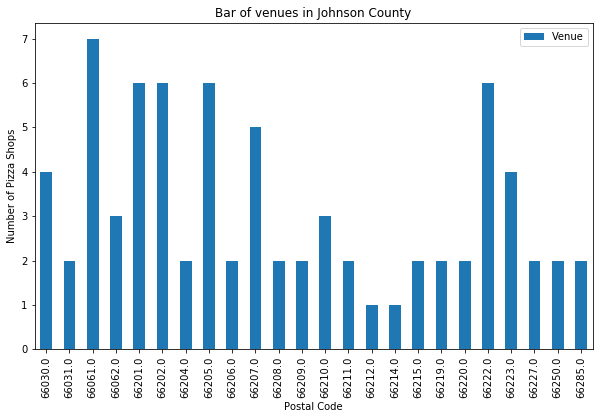

In [62]:

df_pizzaneigh.plot(kind='bar',stacked=False,figsize=(10,6))
import matplotlib.pyplot as plt
plt.title('Bar of venues in Johnson County') # add a title to the histogram
plt.ylabel('Number of Pizza Shops') # add y-label
plt.xlabel('Postal Code') # add x-label

plt.show()

From the above to datasets,  I noticed that Leawood/overland park (zip code 66211) and lenexa/Olathe (zip code 66062) neighborhoods have the high population density and household income, but low pizza shop density (compared with 66030 and 66061 neighborhoods). 
Thus, next step of my analysis will be narrowed down to these two areas. 
Next, I will turn to regression and classification models to train and test my data. Regression analysis mathematically describes the relationship between a set of independent variables and a dependent variable. Classification model attempts to draw some conclusion from observed values. Classification model will predict the outcome with given inputs. In my case, venue location close to city center, venue crossstreet, venue distance to entrance, neighborhood annual payroll, and neighborhood employee numbers are variables which will be used to predict the binary dependent variable---whether it is appropriate to open the pizza shop in the chosen area. 
 

Then which model is best to choose? SVM works well with unstructured and semi-structured data like text and images while logistic regression works with already identified independent variables; SVM is based on geometrical properties of the data while logistic regression is based on statistical approaches.  

I will first try to use logistic regression to see how the model does, and then try using SVM RBF kernel.  I will also try decision tree model since this binary classifier share these traits: Easy to understand; able to find odd interactions; and make minimal assumptions.  

### Predict the pizza place location with Logistic Regression model

Select some featurs for modeling. Also I change the target data type to be integer, as it is a requirement by the skitlearn algorithm:

In [63]:
pizza_df=df_kcjonson[['Venue Latitude','Venue Longitude','Venue Dis to entrance', 'Venue Category','Venue crosssSreet','Employee No.','Ann payroll','Postal Code']]
pizza_df['Venue Category']=pizza_df['Venue Category'].astype('int')
pizza_df.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Venue Latitude,Venue Longitude,Venue Dis to entrance,Venue Category,Venue crosssSreet,Employee No.,Ann payroll,Postal Code
0,39.030392,-94.713196,1396,0,0.0,1280.0,64208.0,66218.0
1,39.029862,-94.713282,1447,0,0.0,1280.0,64208.0,66218.0
2,39.041227,-94.723396,281,0,0.0,1280.0,64208.0,66218.0
3,39.041802,-94.730938,928,0,1.0,1280.0,64208.0,66218.0
4,39.049750,-94.723537,941,0,1.0,1280.0,64208.0,66218.0


In [64]:
print(pizza_df.shape)
print(pizza_df.isna().sum())
print(pizza_df.dtypes)

(1789, 8)
Venue Latitude            0
Venue Longitude           0
Venue Dis to entrance     0
Venue Category            0
Venue crosssSreet         0
Employee No.             10
Ann payroll              10
Postal Code               0
dtype: int64
Venue Latitude           float64
Venue Longitude          float64
Venue Dis to entrance      int64
Venue Category             int64
Venue crosssSreet        float32
Employee No.             float32
Ann payroll              float32
Postal Code              float32
dtype: object


In [65]:
pizza_df=pizza_df.dropna()


In [66]:
X = np.asarray(pizza_df[['Venue Latitude','Venue Longitude','Venue Dis to entrance','Venue crosssSreet','Employee No.','Ann payroll','Postal Code']])
X[0:5]

array([[ 3.90303918e+01, -9.47131959e+01,  1.39600000e+03,
         0.00000000e+00,  1.28000000e+03,  6.42080000e+04,
         6.62180000e+04],
       [ 3.90298616e+01, -9.47132818e+01,  1.44700000e+03,
         0.00000000e+00,  1.28000000e+03,  6.42080000e+04,
         6.62180000e+04],
       [ 3.90412268e+01, -9.47233964e+01,  2.81000000e+02,
         0.00000000e+00,  1.28000000e+03,  6.42080000e+04,
         6.62180000e+04],
       [ 3.90418017e+01, -9.47309385e+01,  9.28000000e+02,
         1.00000000e+00,  1.28000000e+03,  6.42080000e+04,
         6.62180000e+04],
       [ 3.90497503e+01, -9.47235366e+01,  9.41000000e+02,
         1.00000000e+00,  1.28000000e+03,  6.42080000e+04,
         6.62180000e+04]])

In [67]:
y = np.asarray(pizza_df['Venue Category'])
y

array([0, 0, 0, ..., 0, 0, 0])

In [68]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 1.44495679, -0.10889124,  1.18519495, -1.4341203 , -0.8917238 ,
        -0.78218142,  0.24390497],
       [ 1.43459853, -0.11020649,  1.35874043, -1.4341203 , -0.8917238 ,
        -0.78218142,  0.24390497],
       [ 1.65660287, -0.26512892, -2.60898553, -1.4341203 , -0.8917238 ,
        -0.78218142,  0.24390497],
       [ 1.66783323, -0.38064861, -0.40733999,  0.69729157, -0.8917238 ,
        -0.78218142,  0.24390497],
       [ 1.82309869, -0.26727672, -0.36310291,  0.69729157, -0.8917238 ,
        -0.78218142,  0.24390497]])

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


Train set: (1423, 7) (1423,)
Test set: (356, 7) (356,)


In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=1.0, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [71]:
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)


In [72]:
from sklearn.metrics import jaccard_similarity_score
print("LR Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat))

LR Jaccard score: 0.9579


In [73]:
from sklearn.metrics import f1_score 
print("LR Avg F1-score: %.4f" % f1_score(y_test, yhat, average='weighted'))

LR Avg F1-score: 0.9373


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Predict the pizza place location with SVM

In [79]:
import matplotlib.pyplot as plt

In [80]:
X = np.asarray(pizza_df[['Venue Latitude','Venue Longitude','Venue Dis to entrance','Venue crosssSreet','Employee No.','Ann payroll','Postal Code']])
y = np.asarray(pizza_df['Venue Category'])
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (1067, 7) (1067,)
Test set: (712, 7) (712,)


In [81]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [82]:
yhat = clf.predict(X_test)
yhat [0:5]

array([0, 0, 0, 0, 0])

In [84]:
print("SVM Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat))
print("SVM Avg F1-score: %.4f" % f1_score(y_test, yhat, average='weighted'))

SVM Jaccard score: 0.9593
SVM Avg F1-score: 0.9421


### Prediction with Decision Tree Model

In [85]:
df_dt=df_kcjonson.dropna().copy()

df_dt.loc[df_dt['Venue Category'] == 1, 'Venue Category'] = 'Pizza Place'
df_dt.loc[df_dt['Venue Category'] != 'Pizza Place', 'Venue Category'] = 'others'

df_dt['Venue Category']




0       others
1       others
2       others
3       others
4       others
         ...  
1784    others
1785    others
1786    others
1787    others
1788    others
Name: Venue Category, Length: 1779, dtype: object

In [86]:
X_dt = np.asarray(pizza_df[['Venue Latitude','Venue Longitude','Venue Dis to entrance','Venue crosssSreet','Employee No.','Ann payroll','Postal Code']])
y_dt = df_dt['Venue Category']
X_dttrain, X_dttest, y_dttrain, y_dttest = train_test_split( X_dt, y_dt,test_size=0.3, random_state=4)
print ('Train set:', X_dttrain.shape,  y_dttrain.shape)
print ('Test set:', X_dttest.shape,  y_dttest.shape)

Train set: (1245, 7) (1245,)
Test set: (534, 7) (534,)


In [88]:
from sklearn.tree import DecisionTreeClassifier
pizzaTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
pizzaTree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [89]:
pizzaTree.fit(X_dttrain,y_dttrain)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [90]:
predTree = pizzaTree.predict(X_dttest)
print (predTree [0:5])
print (y_dttest [0:5])


['others' 'others' 'others' 'others' 'others']
1757    others
487     others
1585    others
147     others
102     others
Name: Venue Category, dtype: object


In [91]:
from sklearn import metrics
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_dttest, predTree))
 
 

DecisionTrees's Accuracy:  0.9681647940074907


In [92]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pydotplus-2.0.2            |     pyhd1c1de3_3          23 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          23 KB

The following NEW packages will be INSTALLED:

  pydotplus          conda-forge/noarch::pydotplus-2.0.2-pyhd1c1de3_3



pydotplus-2.0.2      | 23 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - python-graphviz


The following packages will be downloaded:

    package 

In [45]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

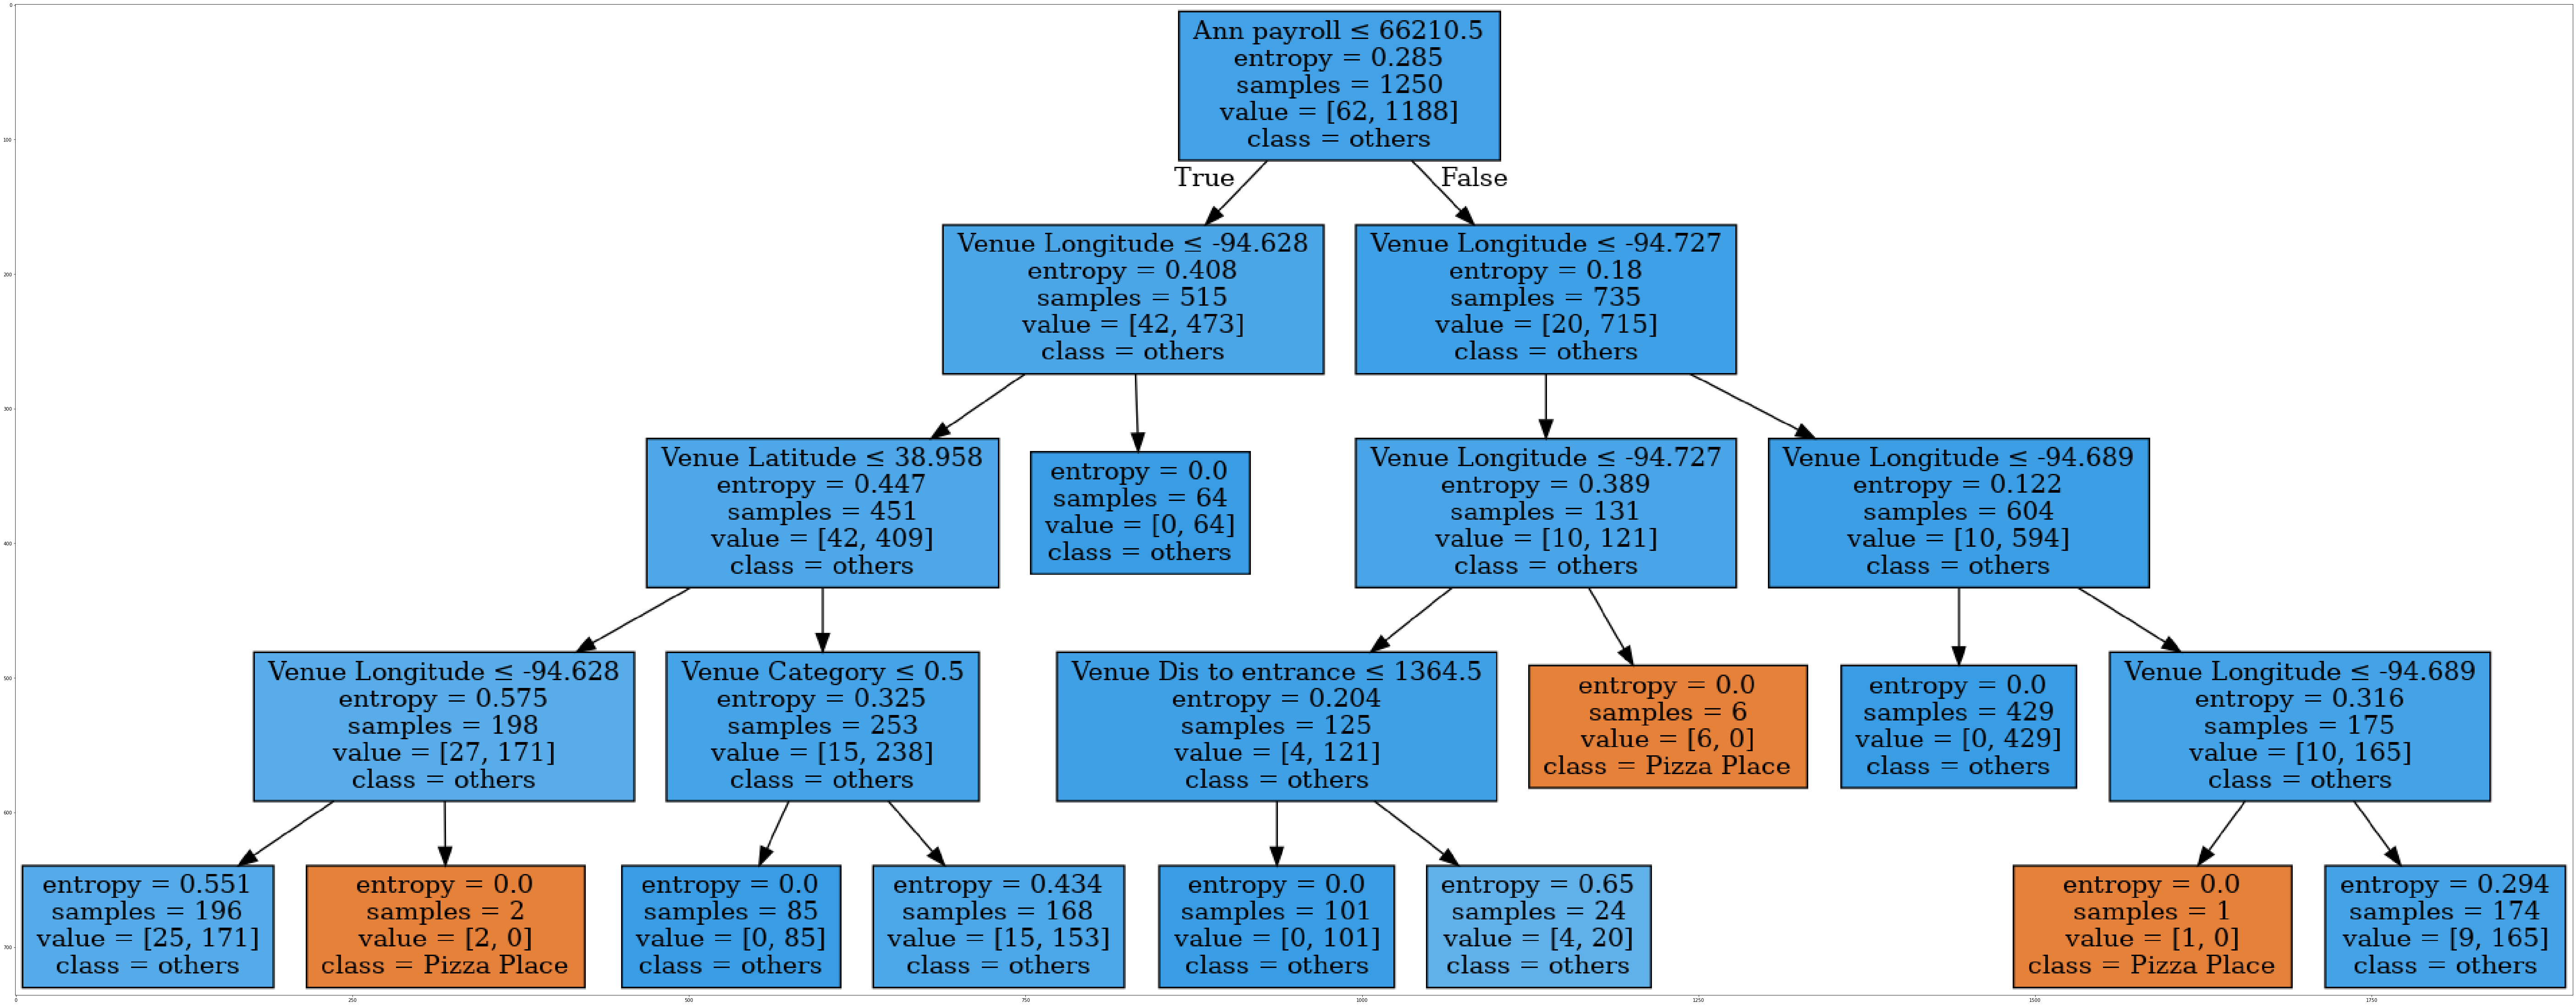

In [67]:
dot_data = StringIO()
filename = "pizzatree.png"
featureNames = pizza_df.columns[0:7]
targetNames = df_dt['Venue Category'].unique().tolist()
out=tree.export_graphviz(pizzaTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_dttrain), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

Performance of SVM and logistic regression model:
SVM model has a higher Avg F1 score and Jaccard score. If A potential location in Overland park/Olathe/shawnee mission/leawood area has been chosen, I can add this address to my model and predict whether the predicted dependent variable equals to my expected outcome---opening a pizza place. 

In my model, my pizza shop dataset is quite imbalanced. I have a 2 class (binary) classification of venue types(pizza shop and others) with 1778 instances. Only 77 instances are labeled with Pizza Shops and the remaining instances are labeled with others. Under this circumstance, I would choose the classifier that get high F1 scores and Jaccard.  score. From the Decision tree model,  I can tell from the train/test datasets: most of the pizza places are clustered in western Johnson County neighborhood with easy access to entrance. 

## 5. Results <a name="results"></a>

The results can be explained in the following areas:

Competition--- Being too close to established competition may help with marketing, but if too close to your competition, the shop owner will have a tough time gaining benefits in the community. The best location for a pizza business would be close to all other categories of  business venues while comparably staying away from most pizza shops.The folium map of the business density and especially pizza shops density show Overland Park/Leawood neighborhood having a high density of business venues while low density of pizza shops. 

Visibility---Though you want to be careful not to place yourself in the position of losing customers because traffic is too heavy near your restaurant, you also want to ensure that you are visible to drive-by and foot traffic. Actually, the most busy street in Overland park/Olathe/Shawnee mission/Leawood area is street line between Kansas and Missouri State, 119th and 135th street. However, the crossroads on these street are perfect for customer to get access to business. They are not as busy as New York Downtown which can not even finding a parking lot. 

Access---One of the most important factors is how accessible your potential location is. The accessibility of cars makes it as easy as possible for customers to visit the pizza place. Distance to entrance and crossStreet accessibility have been added as parameters to establish the regression and classification models. 

Demographics---Demographics are the statistical factor of marketing used to identify population segments by characteristics. Businesses must have a targeted approach to customers. Census business surveys provides employee numbers and employee payroll incomes data regarding how many potential customers and local economy at community level. Leawood/Overland Park (zip 66211) and Lenexa/Olathe(zip 66062) are the two top areas with high level in both elements. 



## 6. Discussion <a name="discussion"></a>

My machine learning models in this project are built based on imbalanced datasets. Out of the total 1778 business venues I selected in Johnson County areas, only 77 of them are pizza shops. Data imbalance reflects an unequal distribution of classes within a dataset. When training on imbalanced data set, this classifier will favor the majority classes and create a biased model. Further analysis and studies will be applied to fix the imbalanced data set. For example, BalancedBaggingClassifier could be used to resampling of each subset of the dataset before training each estimator of the ensemble. That way, I can train a classifier that will handle the imbalance without having to undersample or oversample manually before training. 

In addition, the accuracy and precision of the model is restricted to parameters chosen. Some of the factors to consider the location have not been added to my analysis: the size of their parking lots, the location in relation to your equipment and food suppliers, real estate availability, labor costs, safety/crime rates, and other important factors. Business stakeholders have to take account the above elements to make location decision. 


## 7. Conclusion <a name="conclusion"></a>

The purpose of this project is to find a perfect location to start a pizza business in Johnson County, KS local area. By collecting business venue location, venue category, distance to entrance, cross Street, neighborhood employees, neighborhood wealthiness information from Foursquare & Census business database, I am able to analyze on pizza business competition from pizza shop density map using k-means cluster model. After taking account of the census demographics data, I conclude that the two neighborhood which would be the best location to open the pizza hut are Leawood/Overland Park (zip 66211) and Lenexa/Olathe(zip 66062). Next, the logistic regression model and decision tree model are built to narrow down the location chosen by making binary classification of venue types(pizza shop and others). The business stakeholder now are able to tell whether the location they choose in 66211 and 66062 neighborhood is perfect to start the new business. 


Other elements, like the location in relation to your equipment and food suppliers, real estate availability, labor costs, safety/crime rates and other important factors, will be considered to help the pizza shop owner to make the final decision. 

 